In [1]:
import sys
import time
import torch
import matplotlib.pyplot as plt
sys.path.append('../src')

from generator import *
from evaluation import *
from fair_model import FairModel
from baselines import LR, CvxFairModel, EOFairModel
from utils import gen_plot_data, plot_axes, combine_tuples

In [2]:
# build Bank model
bank = Bank()
agent_train = Agent(n_samples=4000, protect_ratio=0.5, eps=0.5, base=[0.2, 1.0], seed=2021)
agent_test = Agent(n_samples=1000, protect_ratio=0.5, eps=0.5, base=[0.2, 1.0], seed=2020)

In [3]:
# generate datasets
s_train, Xs_train, Ys_train = gen_multi_step_profiles(bank, agent_train, steps=5)
s_test, Xs_test, Ys_test = gen_multi_step_profiles(bank, agent_test, steps=5)
s_comb, X_comb, Y_comb = combine_tuples(s_train, Xs_train, Ys_train)

Retraining Done!
Retraining Done!
Retraining Done!
Retraining Done!


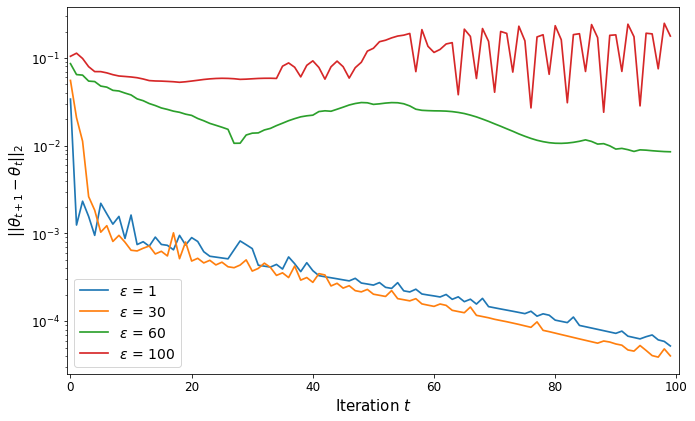

In [4]:
fig = plt.figure(figsize=(10, 6))
eps_list = [1, 30, 60, 100]

for c, eps in enumerate(eps_list):
    agent_train.set_eps(eps)

    # Ours
    fm = FairModel(n_features=len(Xs_train[0][0])+1, lr=5e-3, l2_reg=1e-5, sf_reg=0.14, lf_reg=0.19)
    fm.train(s_train, Xs_train, Ys_train, Xs_train, Ys_train, epochs=1000, plot=False)

    num_iters = 100
    theta_true = fm.params

    theta_list = [np.copy(theta_true)]
    theta_gaps = []

    # inital theta
    theta = np.copy(theta_true)
    for t in range(num_iters):

        # adjust distribution to current theta
        _, NXs_train, NYs_train = gen_multi_step_profiles(fm, agent_train, steps=5)
        # learn on induced distribution
        fm.train(s_train, Xs_train, Ys_train, NXs_train, NYs_train, epochs=10, plot=False)
        
        # keep track of statistic
        theta_new = fm.params
        theta_gaps.append(np.linalg.norm(theta_new - theta))
        theta_list.append(np.copy(theta_new))

        theta = np.copy(theta_new)
    print("Retraining Done!")

    processed_theta_gaps = [x for x in theta_gaps if x != 0.0]
    legend_entry = '$\\varepsilon$ = {}'.format(agent_train.eps)
    plt.plot(processed_theta_gaps, label=legend_entry, linewidth=1.7, alpha=1, zorder=8, linestyle='solid')
    
plt.xlabel('Iteration $t$',fontsize=15)
plt.xlim(-0.5, len(processed_theta_gaps)+0.5)
plt.ylabel(r'$\|\|\theta_{t+1} - \theta_{t}\|\|_2 $', fontsize=15)
plt.yscale('log')
plt.tick_params(labelsize=12)
plt.legend(loc='lower left', fontsize=14)
fig.subplots_adjust(left=0.1, bottom=0.1, right=0.95, top=0.95)
plt.savefig("converge.png", dpi=300)
plt.show()